##### Multiple strategies:

##### Atemporal regression.
Do a standard randomized split on the data.
Train up a polynomial, degree 2 LASSO model on selected parameters from visualizations.
Test model to see if it holds water.
Look at coefficients & suggest interventions to reverse attendance declines.

##### Time series.
Split data into 20th & 21st century, train & test.
Train up a similar model.
See how much adding the time factor adds to the fit (representing external cultural changes).
Change train / test splits as needed.
Project the 2020s with various rules / culture interventions.

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes
import seaborn as sns
%matplotlib inline
sns.set()
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
with open('bat_rate_data.pkl','rb') as cellar:
    bat_df = pickle.load(cellar)
with open('pitch_rate_data.pkl','rb') as cellar:
    pitch_df = pickle.load(cellar)
with open('field_rate_data.pkl','rb') as cellar:
    field_df = pickle.load(cellar)
# with open('sp.pkl','rb') as cellar:
#    sp_df = pickle.load(cellar)
# with open('sb.pkl','rb') as cellar:
#    sb_df = pickle.load(cellar)
with open('att.pkl','rb') as cellar:
    att_df = pickle.load(cellar)

###### Target:
* NormAtt/G * 1000000 (or Att)
= attendance per game in units of parts per million of the U.S. population (using ppm because as a fraction it's really small and seaborn actually gagged on it in some of the pairplots & treated it as zero); the calculation was already done in the visualization notebooks

###### Flagship parameters for model:
* BA, SLG, HR/G, 'SB/G', SH/G, SO9, ERA, DefEff, GmDur

###### "On-deck" parameters:
* IBB/G, 'CS/G', '3B/G', SF/G, DP/G, A/G, Fld% 

In [3]:
y = pd.DataFrame(pitch_df['Att'])
X = [bat_df['BA'],bat_df['SLG'],bat_df['HR/G'],
     bat_df['SB/G'],bat_df['SH/G'],pitch_df['SO9'],
     pitch_df['ERA'],field_df['DefEff'],att_df['GmDur'],
     bat_df['IBB/G'],bat_df['CS/G'],bat_df['3B/G'],
     bat_df['SF/G'],field_df['DP/G'],field_df['A/G'],
     field_df['Fld%']]
X = pd.DataFrame(X)
X = X.transpose()
# X = X.fillna(0)

Let me go back to the visualization notebooks and comment on the distribution of each of these variables individually:
* Att: Bimodal and skewed high.
* BA: Skewed a bit low.
* SLG: Skewed high with a narrow peak.
* HR/G: Oooh. Ugly. Peak at near zero and then a divot and then a skewed low distribution. Should consider dropping that one, or cutting the pre-1920 era which would (check!) get rid of that awful low end.
* SB/G: Ugly, bimodal, both flat square dists.
* SH/G: Ugly, bimodal, the upper end skewed high (dead ball era?).
* SO9: ANOTHER bimodal, big low mode, broad high mode.
* ERA: Just skewed high.
* DefEff: Double peak, skewed high.
* GmDur: Ugly, *tri*modal.
* IBB/G: Mostly normal, split peak, skewed a bit high.
* CS/G: Skewed hard low.
* 3B/G: Bimodal, low mode skewed hard low, upper mode skewed high.
* SF/G: Ugly, patchy, and of course has only been tracked since the 50s.
* DP/G: Narrow single mode with long low tail.
* A/G: Bimodal.
* Fld%: Hard high skew.

#### Conclusion:
I rather think there's a LOT to be said for cutting at 1920 and dropping the dead ball era. The noise in that data is extreme, the trends are different.

In [4]:
y = y.loc[1920:2019]
print(y.head(2),y.tail(2))

            Att
1920  69.425136
1921  64.519993             Att
2018  87.725367
2019  85.906654


In [5]:
X = X.loc[1920:2019]

In [6]:
X.head(2)

,BA,SLG,HR/G,SB/G,SH/G,SO9,ERA,DefEff,GmDur,IBB/G,CS/G,3B/G,SF/G,DP/G,A/G,Fld%
1920,0.276,0.372,0.253247,0.701299,1.233766,2.9,3.46,0.685,NaN,NaN,0.636364,0.512987,NaN,0.798701,13.370130,0.966
1921,0.291,0.403,0.383117,0.603896,1.214286,2.8,4.03,0.677,NaN,NaN,0.532468,0.551948,NaN,0.883117,12.980519,0.966


Ok, let's redo a correlation matrix.

In [7]:
yX = pd.concat([y,X],axis=1)
Rmat = yX.corr()
Rmat.sort_values('Att',ascending=False)

,Att,BA,SLG,HR/G,SB/G,SH/G,SO9,ERA,DefEff,GmDur,IBB/G,CS/G,3B/G,SF/G,DP/G,A/G,Fld%
Att,1.000000,-0.276980,0.398534,0.664850,0.459241,-0.541370,0.630233,0.273438,0.010320,0.689743,-0.196397,0.182858,-0.642233,0.567671,-0.062967,-0.629353,0.754517
Fld%,0.754517,-0.620299,0.322541,0.875272,0.337442,-0.868835,0.932487,0.129550,0.153555,0.941893,-0.405043,-0.110556,-0.938751,0.030554,-0.213739,-0.931195,1.000000
GmDur,0.689743,-0.325505,0.537747,0.883599,0.481140,-0.827851,0.925341,0.324111,-0.273871,1.000000,-0.345199,0.028231,-0.885362,0.104829,-0.476014,-0.883859,0.941893
HR/G,0.664850,-0.405984,0.615283,1.000000,0.201494,-0.799795,0.890854,0.428937,-0.024701,0.883599,-0.473570,-0.224928,-0.799948,-0.083410,-0.107399,-0.901360,0.875272
SO9,0.630233,-0.583830,0.382211,0.890854,0.343233,-0.814189,1.000000,0.149785,-0.003993,0.925341,-0.398711,-0.115840,-0.878625,-0.331557,-0.423654,-0.924675,0.932487
SF/G,0.567671,0.743926,0.277700,-0.083410,0.581738,0.095456,-0.331557,0.399035,-0.283219,0.104829,0.056840,0.537737,0.095794,1.000000,0.352301,0.248539,0.030554
SB/G,0.459241,0.043792,0.214223,0.201494,1.000000,-0.156712,0.343233,0.092082,-0.297500,0.481140,0.140652,0.640674,-0.308980,0.581738,-0.476469,-0.117361,0.337442
SLG,0.398534,0.460079,1.000000,0.615283,0.214223,-0.167932,0.382211,0.935518,-0.713701,0.537747,-0.525476,-0.198151,-0.105824,0.277700,-0.015949,-0.354489,0.322541
ERA,0.273438,0.604029,0.935518,0.428937,0.092082,-0.056693,0.149785,1.000000,-0.728558,0.324111,-0.534978,-0.276169,0.057263,0.399035,0.168058,-0.201162,0.129550
CS/G,0.182858,0.073046,-0.198151,-0.224928,0.640674,0.231182,-0.115840,-0.276169,-0.012306,0.028231,0.511347,1.000000,0.074921,0.537737,-0.245048,0.345667,-0.110556


Keeping in mind insights from below, the top four allowable stats:
* Fld%
* HR/G
* 3B/G
* SO9

That's a nice mix: one apiece of fielding, hitting, speed, pitching.

In [8]:
X = X.fillna(0)
for col in X.columns:
    model = sm.OLS(y,sm.add_constant(X[col]))
    results = model.fit()
    print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    Att   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     8.143
Date:                Thu, 16 Apr 2020   Prob (F-statistic):            0.00527
Time:                        23:29:21   Log-Likelihood:                -433.27
No. Observations:                 100   AIC:                             870.5
Df Residuals:                      98   BIC:                             875.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        201.8327     41.953      4.811      0.0

                            OLS Regression Results                            
Dep. Variable:                    Att   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.3901
Date:                Thu, 16 Apr 2020   Prob (F-statistic):              0.534
Time:                        23:29:22   Log-Likelihood:                -437.06
No. Observations:                 100   AIC:                             878.1
Df Residuals:                      98   BIC:                             883.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.9824     34.878      2.981      0.0

In [9]:
len(X.columns)

16

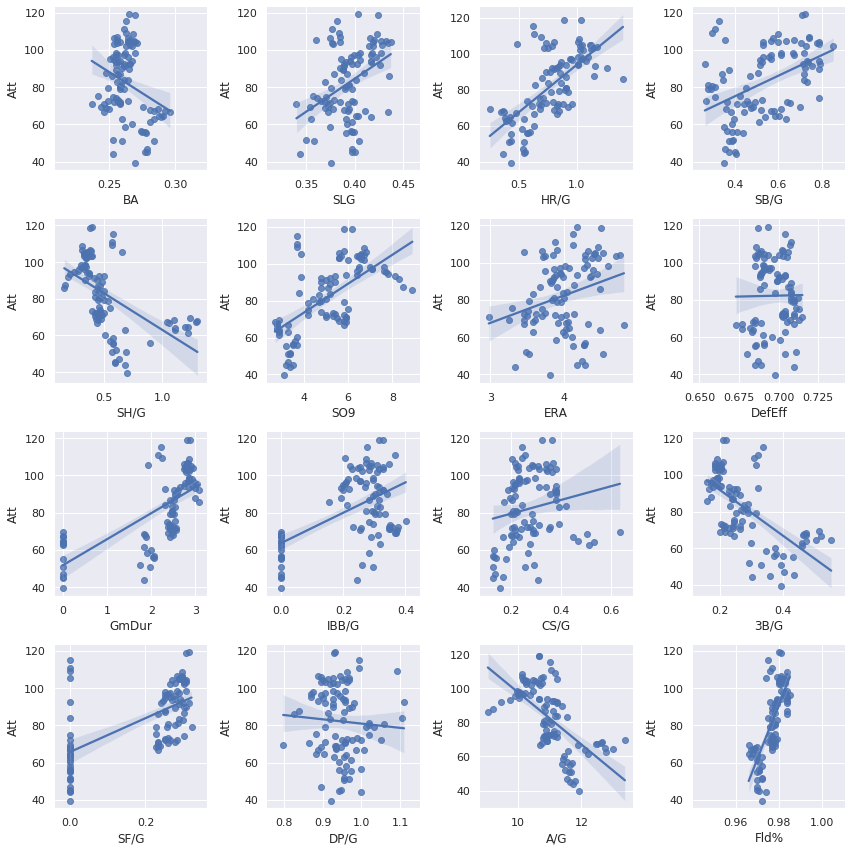

In [10]:
f,axes = plt.subplots(4, 4, figsize=(12,12))
sns.despine(left=True)
for i, col in enumerate(X.columns):
    sns.regplot(X[col],y,ax=axes[i//4,i%4])
plt.tight_layout()

Right. At this point, I think I need to say farewell to GmDur, IBB/G, SF/G just because I don't want to bother with cutting them down to the eras when those stats are available.

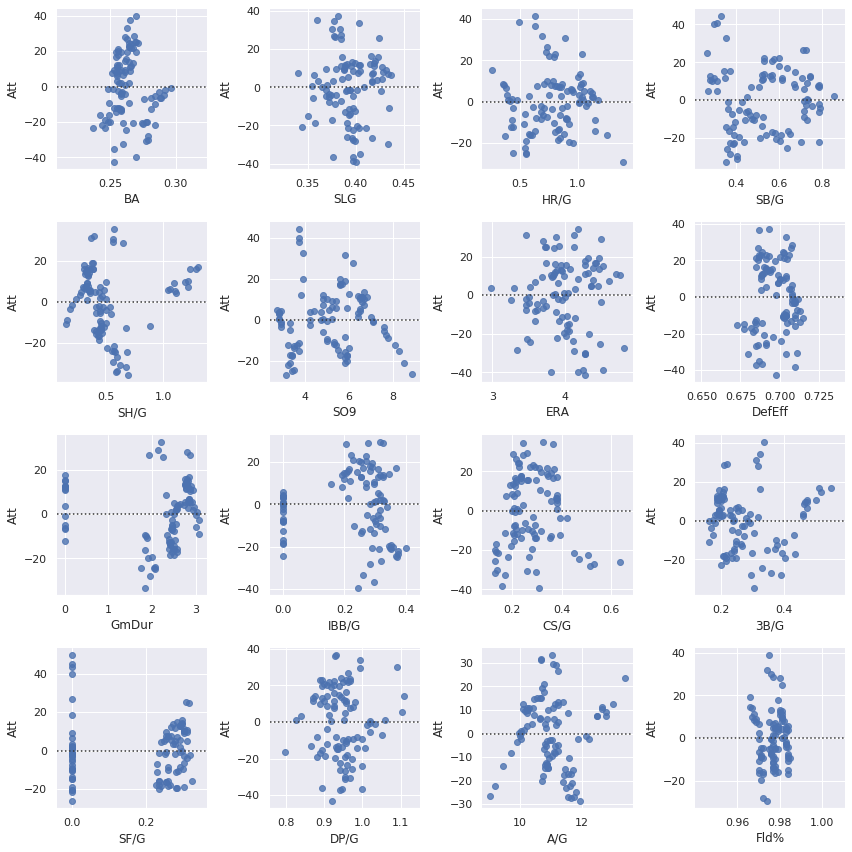

In [11]:
f,axes = plt.subplots(4, 4, figsize=(12,12))
sns.despine(left=True)
for i, col in enumerate(X.columns):
    sns.residplot(X[col],y,ax=axes[i//4,i%4])
plt.tight_layout()

I'm not sure what I've gained beyond looking at the correlation matrix, but by God it looks cool to be able to automate all of that.

Once again, the top four allowable stats:
* Fld%
* HR/G
* 3B/G
* SO9

That's a nice mix: one apiece of fielding, hitting, speed, pitching.
Here's a straight linear regression on those four as a baseline.

In [12]:
# a straight linear regression as a baseline
X1 = pd.concat([X['Fld%'],X['HR/G'],X['3B/G'],X['SO9']],axis=1)

for i in range(3):
    X1tr, X1v, y1tr, y1v = train_test_split(X1, y, test_size=0.3)
    lin_atemp = LinearRegression()
    lin_atemp.fit(X1tr,y1tr)
    print(lin_atemp.score(X1tr,y1tr),lin_atemp.score(X1v,y1v),'\n')
    sm_atemp = sm.OLS(y1tr,sm.add_constant(X1tr))
    at_res = sm_atemp.fit()
    print(at_res.summary(),'\n')

0.5999448775869417 0.7170906601728014 

                            OLS Regression Results                            
Dep. Variable:                    Att   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     24.37
Date:                Thu, 16 Apr 2020   Prob (F-statistic):           2.40e-12
Time:                        23:30:23   Log-Likelihood:                -268.69
No. Observations:                  70   AIC:                             547.4
Df Residuals:                      65   BIC:                             558.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -

That's a wee bit disturbing, the way HR/G has high p-values for 2 out of 3 splits.

0.5881344961009638 0.7810417443852159 



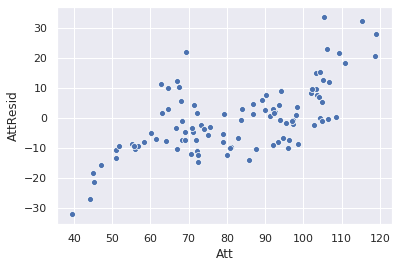

In [13]:
X1tr, X1v, y1tr, y1v = train_test_split(X1, y, test_size=0.3)
lin_atemp = LinearRegression()
lin_atemp.fit(X1tr,y1tr)
print(lin_atemp.score(X1tr,y1tr),lin_atemp.score(X1v,y1v),'\n')
yp = lin_atemp.predict(X1)
ypdf = pd.DataFrame(yp,index=y.index,columns=['PredAtt'])
yres = pd.DataFrame(y['Att']-ypdf['PredAtt'],index=y.index,columns=['AttResid'])
yplot = pd.concat([y,yres],axis=1)
sns.scatterplot(x='Att',y='AttResid',data=yplot)

0.5956151129585128 0.7597576619098965 



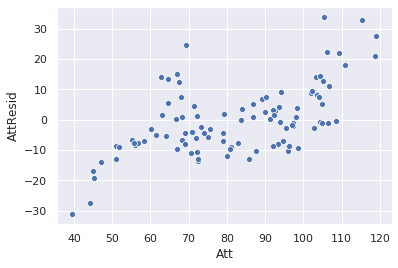

In [14]:
X1tr, X1v, y1tr, y1v = train_test_split(X1, y, test_size=0.3)
lin_atemp = LinearRegression()
lin_atemp.fit(X1tr,y1tr)
print(lin_atemp.score(X1tr,y1tr),lin_atemp.score(X1v,y1v),'\n')
yp = lin_atemp.predict(X1)
ypdf = pd.DataFrame(yp,index=y.index,columns=['PredAtt'])
yres = pd.DataFrame(y['Att']-ypdf['PredAtt'],index=y.index,columns=['AttResid'])
yplot = pd.concat([y,yres],axis=1)
sns.scatterplot(x='Att',y='AttResid',data=yplot)

0.6056461256394596 0.7294046433274906 



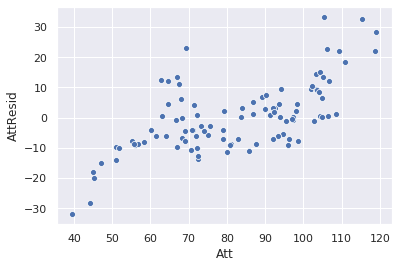

In [15]:
X1tr, X1v, y1tr, y1v = train_test_split(X1, y, test_size=0.3)
lin_atemp = LinearRegression()
lin_atemp.fit(X1tr,y1tr)
print(lin_atemp.score(X1tr,y1tr),lin_atemp.score(X1v,y1v),'\n')
yp = lin_atemp.predict(X1)
ypdf = pd.DataFrame(yp,index=y.index,columns=['PredAtt'])
yres = pd.DataFrame(y['Att']-ypdf['PredAtt'],index=y.index,columns=['AttResid'])
yplot = pd.concat([y,yres],axis=1)
sns.scatterplot(x='Att',y='AttResid',data=yplot)

I am calculating the residual as real - predicted, meaning that the model is consistently overpredicting at low real attendance and underpredicting at high real attendance. Polynomial features should be able to do a considerable amount for this.

This model is certainly unstable; I guess I'm not surprised, with only 119 data points. Hopefully I don't have to go back and rethink things completely and try to pull data at the team... or player... level. I don't know that I would have any attendance data to work with.

Of course, I'm throwing messy, random variables into the regression that probably really are unrelated to attendance trends. I can do three things about this:
* Lasso may be able to prune the crap variables in an automated way.
* I'll do Ridge since it's there.
* If I have to, I can go back to my visualizations and prune variables manually.

Beyond that, there is polynomial feature selection. Forgot about that. There would be a blizzard of features at that point, something like as many features as lines of data, if I stick all of X1 in there, so I'll need to prune that down regardless.

At the moment, though, the guidance suggests I try a "full" model with all features. That will probably be a dumpster fire, but there might be some interesting details in the ashes.

In [16]:
del X['GmDur']
del X['IBB/G']
del X['SF/G']

In [17]:
for i in range(4):
    Xtr, Xv, ytr, yv = train_test_split(X, y, test_size=0.3)
    lin_atemp = LinearRegression()
    lin_atemp.fit(Xtr,ytr)
    print(lin_atemp.score(Xtr,ytr),lin_atemp.score(Xv,yv),'\n')
    sm_atemp = sm.OLS(ytr,sm.add_constant(Xtr))
    at_res = sm_atemp.fit()
    print(at_res.summary(),'\n')

0.8289294239719535 0.6832270983312945 

                            OLS Regression Results                            
Dep. Variable:                    Att   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     20.87
Date:                Thu, 16 Apr 2020   Prob (F-statistic):           7.20e-17
Time:                        23:31:51   Log-Likelihood:                -244.40
No. Observations:                  70   AIC:                             516.8
Df Residuals:                      56   BIC:                             548.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -

Compared to what I've seen up to now, that's pretty consistent overfitting. Let's run a handful of Lassos on these bad boys and see who survives.

In [18]:
scaler = StandardScaler()

In [19]:
print(y)
y = np.ravel(y)
print(y)

            Att
1920  69.425136
1921  64.519993
1922  64.706951
1923  62.822689
1924  68.311279
...         ...
2015  94.651322
2016  93.302161
2017  92.027447
2018  87.725367
2019  85.906654

[100 rows x 1 columns]
[ 69.4251362   64.51999263  64.70695139  62.8226887   68.31127859
  67.07243374  67.87052811  67.43951613  61.35590407  64.06339821
  66.70458239  55.22412125  45.30599167  39.54451346  45.05024927
  47.00196464  50.9800859   56.00838379  56.72469573  55.72279951
  60.14986376  58.38830585  51.8166988   44.09828872  51.03323699
  62.98149075 105.48129288 110.93457295 115.33792539 109.27005831
  92.63150982  84.03279959  74.96033005  72.41228618  79.016132
  81.15470379  79.0526939   80.10815211  80.84400732  86.95383231
  89.16256158  71.9255267   70.68725206  66.83047981  68.20053155
  71.16314977  79.32437932  75.51205274  70.83354093  69.03493191
  72.11411851  72.53683906  69.10909957  73.12538342  72.18611176
  71.32009075  74.07356448  83.5724664   86.85416479  92.188

In [20]:
# Lasso
for i in range(5):
    Xtr, Xv, ytr, yv = train_test_split(X, y, test_size=0.2)
    Xsc = scaler.fit_transform(Xtr.values)
    Xvsc = scaler.fit_transform(Xv.values)
    lasso_atemp = LassoCV()
    lasso_atemp.fit(Xtr,ytr)
    print(lasso_atemp.score(Xtr,ytr),lasso_atemp.score(Xv,yv))

0.6899611262499326 0.46848732784300406
0.7355348431455878 0.578188134946446
0.7322030775873858 0.6279351280961254
0.7687249196594285 0.37436324738780546
0.7413987392862698 0.5292053758089015


Ugh. Those two <0.3 scores on the first two runs are quite chilling. I guess 5 runs is not a good sample size for this...

In [21]:
# Ridge
for i in range(5):
    Xtr, Xv, ytr, yv = train_test_split(X, y, test_size=0.3)
    Xsc = scaler.fit_transform(Xtr.values)
    Xvsc = scaler.fit_transform(Xv.values)
    ridge_atemp = RidgeCV()
    ridge_atemp.fit(Xtr,ytr)
    print(ridge_atemp.score(Xtr,ytr),ridge_atemp.score(Xv,yv))

0.6694025690716199 0.7010652656673999
0.6871719500562723 0.7438068675609468
0.6906618188011233 0.760251251212555
0.7431302545714252 0.5879634804294609
0.6871745062593813 0.7639640784157686


That's just bad, not so terrible.

Let me run the Lasso code again and look at the coefficients.

In [22]:
# Lasso
for i in range(5):
    Xtr, Xv, ytr, yv = train_test_split(X, y, test_size=0.3)
    Xsc = scaler.fit_transform(Xtr.values)
    Xvsc = scaler.fit_transform(Xv.values)
    lasso_atemp = LassoCV()
    lasso_atemp.fit(Xtr,ytr)
    out = pd.DataFrame(lasso_atemp.coef_)
    out = out.transpose().round(decimals=2)
    out.columns=Xtr.columns
    print(out,'\n')
    print(lasso_atemp.score(Xtr,ytr),lasso_atemp.score(Xv,yv),'\n')

    BA  SLG  HR/G   SB/G   SH/G   SO9   ERA  DefEff    CS/G  3B/G   DP/G  \
0  0.0  0.0   0.0  26.18  27.66 -7.83  6.01     0.0  110.01   0.0  50.19   

     A/G  Fld%  
0 -41.77   0.0   

0.7259841344274632 0.6757868625168537 

    BA  SLG  HR/G   SB/G  SH/G   SO9   ERA  DefEff   CS/G   3B/G  DP/G    A/G  \
0  0.0  0.0  -0.0  29.56  38.6 -7.92  8.14     0.0  95.58 -31.76  88.6 -41.07   

   Fld%  
0   0.0   

0.7011545848506868 0.7411367122599142 

    BA  SLG  HR/G   SB/G   SH/G   SO9  ERA  DefEff   CS/G  3B/G   DP/G    A/G  \
0  0.0  0.0  3.32  41.21  33.74 -5.44  6.5     0.0  81.36  -0.0  62.44 -35.96   

   Fld%  
0   0.0   

0.6980586912609066 0.7652171799824816 

    BA  SLG  HR/G   SB/G  SH/G    SO9   ERA  DefEff   CS/G   3B/G   DP/G  \
0  0.0  0.0  24.5  50.02  40.9 -10.38 -0.68     0.0  73.96 -12.66  34.72   

     A/G  Fld%  
0 -39.41   0.0   

0.7433055613903504 0.6277364330736714 

    BA  SLG   HR/G   SB/G   SH/G   SO9   ERA  DefEff   CS/G  3B/G  DP/G  \
0 -0.0  0.0  11.4

Features with all zero coefficients:
BA, SLG, DefEff, Fld%

Features with consistent coefficients:
* A/G - of all things. Always negative and reasonably constant magnitude.

Features with consistent sign:
* HR/G - always positive. (Chicks dig the long ball.)
* SB/G - always positive.
* SH/G (bunts) - always positive.
* SO9 - always negative.
* ERA - always positive.
* CS - always positive.
* DP/G - always positive...hanging on that once...

Other:
* 3B/G - sometimes negative, sometimes zero.

In [23]:
# Ridge
for i in range(5):
    Xtr, Xv, ytr, yv = train_test_split(X, y, test_size=0.3)
    Xsc = scaler.fit_transform(Xtr.values)
    Xvsc = scaler.fit_transform(Xv.values)
    ridge_atemp = RidgeCV()
    ridge_atemp.fit(Xtr,ytr)
    out = pd.DataFrame(ridge_atemp.coef_)
    out = out.transpose().round(decimals=2)
    out.columns=Xtr.columns
    print(out,'\n')
    print(ridge_atemp.score(Xtr,ytr),ridge_atemp.score(Xv,yv),'\n')

    BA   SLG   HR/G   SB/G   SH/G   SO9   ERA  DefEff  CS/G   3B/G   DP/G  \
0 -1.1  1.34  16.35  38.53  31.35 -6.25  1.33    4.17  64.6 -17.78  41.12   

    A/G  Fld%  
0 -29.6  3.87   

0.7637299323776664 0.555719592582004 

    BA   SLG   HR/G   SB/G   SH/G   SO9   ERA  DefEff   CS/G   3B/G  DP/G  \
0  2.2  4.05  13.26  41.99  30.42 -8.74  2.71    3.29  60.44 -22.66  54.4   

     A/G  Fld%  
0 -35.92  5.75   

0.726146949458385 0.6579905349403408 

     BA   SLG  HR/G   SB/G   SH/G   SO9   ERA  DefEff   CS/G   3B/G   DP/G  \
0 -1.21  1.06  8.92  35.14  26.85 -5.41  5.14    4.58  70.92 -24.44  38.22   

     A/G  Fld%  
0 -29.43  5.13   

0.7177222020438689 0.6186333861435668 

     BA   SLG   HR/G   SB/G   SH/G   SO9   ERA  DefEff   CS/G   3B/G  DP/G  \
0  0.05  2.41  24.53  39.08  25.62 -5.97  5.22    5.12  65.16 -11.24  31.0   

     A/G  Fld%  
0 -28.09  5.13   

0.7371586487754895 0.5698795023813996 

     BA   SLG   HR/G   SB/G  SH/G   SO9   ERA  DefEff   CS/G   3B/G   DP/G  

Oscillating signs:
* BA, SLG

Doesn't provide a lot of other guidance. On this showing, the other 11 features could all be valuable.

Features with |corr| > 0.74 with Att: (from the early form of the bb-regress notebook, may not quite jive with the above)
* HR/G
* A/G
* Fld%
* 3B/G

Features with 0.67 < |corr| < 0.74 with Att:
* GmDur
* SF/G
* SH/G
* SO9
* IBB/G

The top four allowable stats from above, based on correlation coefficient and data coverage, were:

    Fld%
    HR/G
    3B/G
    SO9

Taking the lasso results into account, I think I will bump Fld% and replace it with A/G after all. That still has the same mixture of hitting, pitching, speed, and fielding metrics. 

I realize that precisely because there is probably a polynomial relationship between a number of these variables, the linear correlation coefficients may be bad for important variables, but this is where I'll start. I wish I could just throw six or ten features in, poly=2 them, and regress against 10,000 data points, but I've backed myself into this problem, still suspect it's worth trying, and I will do what I can. After this first cut I will consult the pairplots in my visualization notebooks again to look for arched data.

In [24]:
Xp = pd.concat([X['HR/G'],X['SO9'],X['3B/G'],X['A/G']],axis=1)
Xp.head(2)

,HR/G,SO9,3B/G,A/G
1920,0.253247,2.9,0.512987,13.370130
1921,0.383117,2.8,0.551948,12.980519


In [25]:
pf = PolynomialFeatures(degree=2)
pf.fit(Xp)
pf.get_feature_names(input_features=list(Xp.columns))

['1',
 'HR/G',
 'SO9',
 '3B/G',
 'A/G',
 'HR/G^2',
 'HR/G SO9',
 'HR/G 3B/G',
 'HR/G A/G',
 'SO9^2',
 'SO9 3B/G',
 'SO9 A/G',
 '3B/G^2',
 '3B/G A/G',
 'A/G^2']

In [26]:
Xparr = pf.transform(Xp)
Xparr

array([[1.00000000e+00, 2.53246753e-01, 2.90000000e+00, ...,
        2.63155675e-01, 6.85870299e+00, 1.78760373e+02],
       [1.00000000e+00, 3.83116883e-01, 2.80000000e+00, ...,
        3.04646652e-01, 7.16457244e+00, 1.68493886e+02],
       [1.00000000e+00, 4.25806452e-01, 2.80000000e+00, ...,
        2.53236212e-01, 6.41856400e+00, 1.62685911e+02],
       ...,
       [1.00000000e+00, 1.25925926e+00, 8.30000000e+00, ...,
        2.77777778e-02, 1.57716049e+00, 8.95476680e+01],
       [1.00000000e+00, 1.14814815e+00, 8.50000000e+00, ...,
        2.98734949e-02, 1.58862978e+00, 8.44810623e+01],
       [1.00000000e+00, 1.39506173e+00, 8.90000000e+00, ...,
        2.57582686e-02, 1.45137936e+00, 8.17796449e+01]])

In [27]:
Xparr_cols = pf.get_feature_names(input_features=list(Xp.columns))
Xpp = pd.DataFrame(Xparr,columns=Xparr_cols,index=Xp.index)
Xpp.head(2)

,1,HR/G,SO9,3B/G,A/G,HR/G^2,HR/G SO9,HR/G 3B/G,HR/G A/G,SO9^2,SO9 3B/G,SO9 A/G,3B/G^2,3B/G A/G,A/G^2
1920,1.0,0.253247,2.9,0.512987,13.370130,0.064134,0.734416,0.129912,3.385942,8.41,1.487662,38.773377,0.263156,6.858703,178.760373
1921,1.0,0.383117,2.8,0.551948,12.980519,0.146779,1.072727,0.211461,4.973056,7.84,1.545455,36.345455,0.304647,7.164572,168.493886


In [28]:
for i in range(5):
    Xptr, Xpv, yptr, ypv = train_test_split(Xpp, y, test_size=0.2)
    Xpsc = scaler.fit_transform(Xptr.values)
    Xpvsc = scaler.fit_transform(Xpv.values)
    lasso_atemp = LassoCV()
    lasso_atemp.fit(Xpsc,yptr)
    out = pd.DataFrame(lasso_atemp.coef_)
    out = out.transpose().round(decimals=2)
    out.columns=Xpp.columns
    print(out,'\n')
    print(lasso_atemp.score(Xpsc,yptr),lasso_atemp.score(Xpvsc,ypv),'\n')

/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.964712736220463, tolerance: 2.387552209587727
  tol, rng, random, positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.79769323333494, tolerance: 2.387552209587727
  tol, rng, random, positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.21515933273804, tolerance: 2.387552209587727
  tol, rng, random, positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Object

/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63.66012757947101, tolerance: 2.4959528153341264
  tol, rng, random, positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54.99119238984167, tolerance: 2.4959528153341264
  tol, rng, random, positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49.50631174749833, tolerance: 2.4959528153341264
  tol, rng, random, positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: O

     1   HR/G   SO9  3B/G   A/G  HR/G^2  HR/G SO9  HR/G 3B/G  HR/G A/G  SO9^2  \
0  0.0  69.83 -2.59  0.32 -7.85  -34.32     -26.7     -30.84     38.72   0.72   

   SO9 3B/G  SO9 A/G  3B/G^2  3B/G A/G  A/G^2  
0      4.71   -16.62   17.59     19.57 -16.74   

0.5838192208871764 -0.6832172047393035 



/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.50693502919239, tolerance: 2.0871698087075123
  tol, rng, random, positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.50169823103897, tolerance: 2.0871698087075123
  tol, rng, random, positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52.12583386293045, tolerance: 2.0871698087075123
  tol, rng, random, positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: O

     1   HR/G  SO9  3B/G    A/G  HR/G^2  HR/G SO9  HR/G 3B/G  HR/G A/G  SO9^2  \
0  0.0  55.37 -0.0 -0.63 -10.87  -15.04    -46.08     -32.18     36.02  -0.68   

   SO9 3B/G  SO9 A/G  3B/G^2  3B/G A/G  A/G^2  
0      1.71    -3.09   34.73       7.1 -17.71   

0.5999086608424289 -0.1365337217414866 



/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.781567800051562, tolerance: 2.506014243006826
  tol, rng, random, positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.66471860110869, tolerance: 2.506014243006826
  tol, rng, random, positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.023246679227668, tolerance: 2.506014243006826
  tol, rng, random, positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Obje

     1  HR/G  SO9  3B/G    A/G  HR/G^2  HR/G SO9  HR/G 3B/G  HR/G A/G  SO9^2  \
0  0.0  73.2 -0.0 -0.24 -16.41  -27.77    -39.43     -30.78     29.76    0.0   

   SO9 3B/G  SO9 A/G  3B/G^2  3B/G A/G  A/G^2  
0      1.35    -4.54   29.67      1.79  -1.43   

0.6153610636558304 -1.6221182392755504 



/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.599261071292858, tolerance: 2.4349290178322582
  tol, rng, random, positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44.11094957394744, tolerance: 2.4349290178322582
  tol, rng, random, positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66.51399044445861, tolerance: 2.4349290178322582
  tol, rng, random, positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: 

     1  HR/G  SO9  3B/G   A/G  HR/G^2  HR/G SO9  HR/G 3B/G  HR/G A/G  SO9^2  \
0  0.0  32.1  0.0  -0.0 -18.5    -8.1    -34.12     -20.97     31.71   -0.0   

   SO9 3B/G  SO9 A/G  3B/G^2  3B/G A/G  A/G^2  
0     -0.06      0.0   26.09       0.0   -0.0   

0.5920407013224371 0.6059883729833976 



/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.41451923460954, tolerance: 2.4978990727430297
  tol, rng, random, positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75.76682520573377, tolerance: 2.4978990727430297
  tol, rng, random, positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113.33289572568538, tolerance: 2.4978990727430297
  tol, rng, random, positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: 

     1   HR/G   SO9  3B/G   A/G  HR/G^2  HR/G SO9  HR/G 3B/G  HR/G A/G  SO9^2  \
0  0.0  79.57 -1.81  -0.0 -11.8  -45.93    -24.06     -37.98     44.04   0.88   

   SO9 3B/G  SO9 A/G  3B/G^2  3B/G A/G  A/G^2  
0      6.89   -20.98    9.96     25.53 -11.68   

0.604198516046728 -0.7850591132425011 



/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 89.41742476639956, tolerance: 2.4774440750100553
  tol, rng, random, positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 101.21953421227226, tolerance: 2.4774440750100553
  tol, rng, random, positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 110.08024595291863, tolerance: 2.4774440750100553
  tol, rng, random, positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning:

It converged five times, but it's unstable as hell. Delightful.

I want p values for each polynomial feature to see what that looks like. The coefficients themselves only tell me a little. I can look at some stuff from statsmodels for an interactive model.

Although now that I'm thinking about it, I'm a little ahead of myself, since I haven't actually done a straight linear regression yet as a baseline.

In [29]:
for i in range(5):
    Xptr, Xpv, yptr, ypv = train_test_split(Xpp, y, test_size=0.2)
    Xpsc = scaler.fit_transform(Xptr.values)
    Xpvsc = scaler.fit_transform(Xpv.values)
    lin_atemp = LinearRegression()
    lin_atemp.fit(Xpsc,yptr)
    out = pd.DataFrame(lin_atemp.coef_)
    out = out.transpose().round(decimals=2)
    out.columns=Xpp.columns
    print(out,'\n')
    print(lin_atemp.score(Xpsc,yptr),lin_atemp.score(Xpvsc,ypv),'\n')

     1    HR/G     SO9    3B/G      A/G  HR/G^2  HR/G SO9  HR/G 3B/G  \
0  0.0 -761.86 -610.88  179.32 -1709.03    3.41    217.04      -4.28   

   HR/G A/G  SO9^2  SO9 3B/G  SO9 A/G  3B/G^2  3B/G A/G    A/G^2  
0    537.21 -60.75    -28.04   485.25  -24.77    -85.78  1424.09   

0.6935327130978226 -0.2818235779473466 

     1    HR/G    SO9    3B/G      A/G  HR/G^2  HR/G SO9  HR/G 3B/G  HR/G A/G  \
0  0.0 -683.76 -685.8 -244.18 -1195.49   16.38    149.05      -8.22    503.89   

   SO9^2  SO9 3B/G  SO9 A/G  3B/G^2  3B/G A/G   A/G^2  
0  52.36      -2.6   429.58    -9.1     312.8  882.39   

0.6800120498339477 -0.6125446949829885 

     1    HR/G     SO9  3B/G      A/G  HR/G^2  HR/G SO9  HR/G 3B/G  HR/G A/G  \
0  0.0 -642.91 -651.95  6.42 -1440.15    2.09    201.51      -0.39    441.12   

   SO9^2  SO9 3B/G  SO9 A/G  3B/G^2  3B/G A/G    A/G^2  
0 -32.34    -21.59   491.96  -36.65    108.23  1146.98   

0.6677672634294489 0.19565038143824542 

     1    HR/G     SO9    3B/G      A/G  H

That's incredibly bad overfitting. Let me go back to the lasso results and see if I can store a list of dataframes and pile them together at the end for ease of readout.

In [32]:
output = []
for i in range(5):
    Xptr, Xpv, yptr, ypv = train_test_split(Xpp, y, test_size=0.2)
    Xpsc = scaler.fit_transform(Xptr.values)
    Xpvsc = scaler.fit_transform(Xpv.values)
    lasso_atemp = LassoCV()
    lasso_atemp.fit(Xpsc,yptr)
    out = pd.DataFrame(lasso_atemp.coef_,index=X2s.columns).round(decimals=2)
    out = out.transpose()
    out['TrSc'] = lasso_atemp.score(Xpsc,yptr)
    out['VSc'] = lasso_atemp.score(Xpvsc,ypv)
    out = out.transpose()
    out.columns = [i]
    output.append(out.round(decimals=2))
out_df = pd.concat(output,axis=1)

/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.53338420250111, tolerance: 2.1015755726599825
  tol, rng, random, positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.47679266326941, tolerance: 2.1015755726599825
  tol, rng, random, positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49.285780725105724, tolerance: 2.1015755726599825
  tol, rng, random, positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: O

/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45.54325724058981, tolerance: 2.0783101930936465
  tol, rng, random, positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43.39684286830379, tolerance: 2.0783101930936465
  tol, rng, random, positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.524182236645174, tolerance: 2.0783101930936465
  tol, rng, random, positive)
/home/paulus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: 

NameError: name 'X2s' is not defined

In [33]:
out_df

,0,TrSc,VSc,0,TrSc,VSc,0,TrSc,VSc,0,TrSc,VSc,0,TrSc,VSc
1,0.00,0.58,0.22,0.00,0.61,0.38,0.00,0.61,0.55,0.00,0.63,0.41,0.00,0.62,0.42
HR/G,45.60,0.58,0.22,69.95,0.61,0.38,68.83,0.61,0.55,22.45,0.63,0.41,23.45,0.62,0.42
SO9,0.00,0.58,0.22,-0.00,0.61,0.38,-0.93,0.61,0.55,1.27,0.63,0.41,0.00,0.62,0.42
3B/G,-0.00,0.58,0.22,0.00,0.61,0.38,-0.00,0.61,0.55,-0.00,0.63,0.41,-0.41,0.62,0.42
A/G,-17.28,0.58,0.22,-11.63,0.61,0.38,-8.18,0.61,0.55,-12.12,0.63,0.41,-16.77,0.62,0.42
HR/G^2,-26.13,0.58,0.22,-35.57,0.61,0.38,-32.28,0.61,0.55,-5.07,0.63,0.41,-4.72,0.62,0.42
HR/G SO9,-17.49,0.58,0.22,-19.64,0.61,0.38,-26.14,0.61,0.55,-28.75,0.63,0.41,-28.44,0.62,0.42
HR/G 3B/G,-26.68,0.58,0.22,-29.06,0.61,0.38,-29.18,0.61,0.55,-21.53,0.63,0.41,-19.51,0.62,0.42
HR/G A/G,30.56,0.58,0.22,30.03,0.61,0.38,28.50,0.61,0.55,35.74,0.63,0.41,28.63,0.62,0.42
SO9^2,-9.78,0.58,0.22,0.00,0.61,0.38,3.33,0.61,0.55,0.00,0.63,0.41,-0.00,0.62,0.42


Using my paper notebook to assess two things:
* The statsmodels output on the full linear regression stable.
* The viability of individual variables as linear or lin + quad combos.

Four statsmodels runs had CS/G and Fld% with the lowest p-values.
Three runs also had SH/G, A/G.

* BA looks like two linear trends. Throw it in linear only.
* HR/G is a broad line. Linear, although the above results suggest quadratic.
* SO9: quad + lin
* Pitchers/G: pull this in from att_df and quad + lin
* GmDur: fortunately is close to linearly dependent on Pitchers/G, skip
* 3B: quad + lin
* SH: quad + lin (give the people what they want...)
* Fld%: quad + lin
* A/G: somewhat close to collinear with Fld%
That's 12 parameters (two lins & five quad + lin).
* Consider CS/G from statsmodels, either lin or quad + lin.
I'll try running statsmodels on all 14, then cutting down manually, then compare that to lasso and ridge.

In [34]:
pg = att_df['Pitchers/G']
pg = pg.loc[1920:2019]
X2s = pd.concat([X['BA'],X['HR/G'],X['SO9'],pg,
                X['3B/G'],X['SH/G'],X['Fld%']],axis=1)
X2s['SO9^2'] = X2s['SO9']**2
X2s

,BA,HR/G,SO9,Pitchers/G,3B/G,SH/G,Fld%,SO9^2
1920,0.276,0.253247,2.9,1.62,0.512987,1.233766,0.966,8.41
1921,0.291,0.383117,2.8,1.74,0.551948,1.214286,0.966,7.84
1922,0.288,0.425806,2.8,1.79,0.503226,1.193548,0.968,7.84
1923,0.284,0.396104,2.9,1.81,0.461039,1.110390,0.967,8.41
1924,0.287,0.363636,2.7,1.83,0.474026,1.097403,0.970,7.29
...,...,...,...,...,...,...,...,...
2015,0.254,1.012346,7.8,4.11,0.191358,0.246914,0.984,60.84
2016,0.255,1.154321,8.1,4.15,0.179012,0.209877,0.984,65.61
2017,0.255,1.259259,8.3,4.22,0.166667,0.191358,0.984,68.89
2018,0.248,1.148148,8.5,4.36,0.172840,0.166667,0.984,72.25


In [35]:
X2s['PitG^2'] = X2s['Pitchers/G']**2
X2s['3B^2'] = X2s['3B/G']**2
X2s['SH^2'] = X2s['SH/G']**2
X2s['Fld^2'] = X2s['Fld%']**2

In [36]:
for i in range(4):
    Xtr, Xv, ytr, yv = train_test_split(X2s, y, test_size=0.2)
    lin_atemp = LinearRegression()
    lin_atemp.fit(Xtr,ytr)
    print(lin_atemp.score(Xtr,ytr),lin_atemp.score(Xv,yv),'\n')
    sm_atemp = sm.OLS(ytr,sm.add_constant(Xtr))
    at_res = sm_atemp.fit()
    print(at_res.summary(),'\n')

0.8092450971993213 0.5750680552693086 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     23.69
Date:                Thu, 16 Apr 2020   Prob (F-statistic):           1.52e-19
Time:                        23:35:19   Log-Likelihood:                -276.92
No. Observations:                  80   AIC:                             579.8
Df Residuals:                      67   BIC:                             610.8
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       

Ye don't say.

In [37]:
Xslow = pd.concat([X2s['Pitchers/G'],
                        X2s['PitG^2']],axis=1)
for i in range(4):
    Xtr, Xv, ytr, yv = train_test_split(Xslow, y, test_size=0.2)
    lin_atemp = LinearRegression()
    lin_atemp.fit(Xtr,ytr)
    print(lin_atemp.score(Xtr,ytr),lin_atemp.score(Xv,yv),'\n')
    sm_atemp = sm.OLS(ytr,sm.add_constant(Xtr))
    at_res = sm_atemp.fit()
    print(at_res.summary(),'\n')

0.666834187083264 0.32858327519126607 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     77.06
Date:                Thu, 16 Apr 2020   Prob (F-statistic):           4.19e-19
Time:                        23:35:31   Log-Likelihood:                -304.12
No. Observations:                  80   AIC:                             614.2
Df Residuals:                      77   BIC:                             621.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       

I mean, it would be pretty boring if that were the whole story: "Stop making so damned many pitching swaps!"

Wait. That's the wrong sign. Wait. No, it's not. The game got interesting to a certain point with pitching changes (positive lin term), but too many drags it down (neg square term).

Three pending action items:
* Get Caught Stealing & look at new p-values.
* Lasso this band of stats & compare its results to p-values.
* Consider manually voting stats off the island like back in the old days.

In [38]:
X2s['CS/G'] = X['CS/G']
X2s['CS^2'] = X2s['CS/G']**2

In [39]:
for i in range(4):
    Xtr, Xv, ytr, yv = train_test_split(X2s, y, test_size=0.2)
    lin_atemp = LinearRegression()
    lin_atemp.fit(Xtr,ytr)
    print(lin_atemp.score(Xtr,ytr),lin_atemp.score(Xv,yv),'\n')
    sm_atemp = sm.OLS(ytr,sm.add_constant(Xtr))
    at_res = sm_atemp.fit()
    print(at_res.summary(),'\n')

0.7658308444474693 0.8403960767110956 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     15.18
Date:                Thu, 16 Apr 2020   Prob (F-statistic):           2.07e-15
Time:                        23:35:57   Log-Likelihood:                -292.39
No. Observations:                  80   AIC:                             614.8
Df Residuals:                      65   BIC:                             650.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       

In [41]:
del X2s['SO9^2']
del X2s['SH/G']
del X2s['3B^2']
del X2s['Fld^2']
del X2s['3B/G']

KeyError: 'SO9^2'

In [42]:
del X2s['Fld%']
del X2s['CS^2']

In [43]:
X2s

,BA,HR/G,SO9,Pitchers/G,PitG^2,SH^2,CS/G
1920,0.276,0.253247,2.9,1.62,2.6244,1.522179,0.636364
1921,0.291,0.383117,2.8,1.74,3.0276,1.474490,0.532468
1922,0.288,0.425806,2.8,1.79,3.2041,1.424558,0.470968
1923,0.284,0.396104,2.9,1.81,3.2761,1.232965,0.512987
1924,0.287,0.363636,2.7,1.83,3.3489,1.204292,0.506494
...,...,...,...,...,...,...,...
2015,0.254,1.012346,7.8,4.11,16.8921,0.060966,0.216049
2016,0.255,1.154321,8.1,4.15,17.2225,0.044048,0.203704
2017,0.255,1.259259,8.3,4.22,17.8084,0.036618,0.191358
2018,0.248,1.148148,8.5,4.36,19.0096,0.027778,0.197531


In [44]:
sm_atemp = sm.OLS(y,sm.add_constant(X2s))
at_model = sm_atemp.fit()
print(at_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     40.08
Date:                Thu, 16 Apr 2020   Prob (F-statistic):           2.71e-25
Time:                        23:41:21   Log-Likelihood:                -367.33
No. Observations:                 100   AIC:                             750.7
Df Residuals:                      92   BIC:                             771.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.1657     55.538      0.381      0.7

In [45]:
del X2s['SH^2']

In [46]:
sm_atemp = sm.OLS(y,sm.add_constant(X2s))
at_model = sm_atemp.fit()
print(at_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     45.62
Date:                Thu, 16 Apr 2020   Prob (F-statistic):           1.28e-25
Time:                        23:41:52   Log-Likelihood:                -368.66
No. Observations:                 100   AIC:                             751.3
Df Residuals:                      93   BIC:                             769.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9639     55.017      0.090      0.9

In [47]:
del X2s['BA']

In [48]:
sm_atemp = sm.OLS(y,sm.add_constant(X2s))
at_model = sm_atemp.fit()
print(at_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     52.01
Date:                Thu, 16 Apr 2020   Prob (F-statistic):           1.37e-25
Time:                        23:42:25   Log-Likelihood:                -370.96
No. Observations:                 100   AIC:                             753.9
Df Residuals:                      94   BIC:                             769.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -102.5449     19.829     -5.172      0.0

In [49]:
X3 = X2s.copy()
del X2s['HR/G']

In [50]:
sm_atemp = sm.OLS(y,sm.add_constant(X2s))
at_model = sm_atemp.fit()
print(at_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     62.33
Date:                Thu, 16 Apr 2020   Prob (F-statistic):           9.67e-26
Time:                        23:43:22   Log-Likelihood:                -372.88
No. Observations:                 100   AIC:                             755.8
Df Residuals:                      95   BIC:                             768.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -115.6298     18.879     -6.125      0.0

In [51]:
fin_atemp = LinearRegression()
fin_atemp.fit(X2s,y)
fin_atemp.score(X2s,y)

0.7240923309547138

In [53]:
yo = np.array(y)
yp = np.array(fin_atemp.predict(X2s))
yd = yo - yp

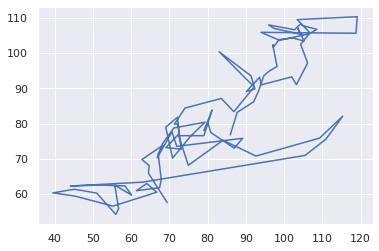

In [55]:
plt.plot(yo,yp)

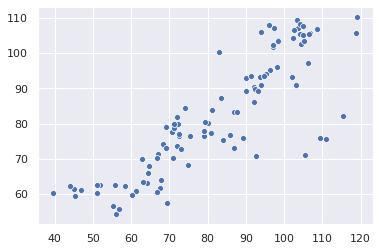

In [56]:
sns.scatterplot(x=yo,y=yp)

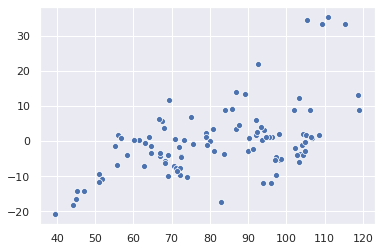

In [57]:
sns.scatterplot(x=yo,y=yd)

In [58]:
yo = yo * 300
yp = yp * 300
yd = yd * 300

Text(0, 0.5, 'Model Deviation')

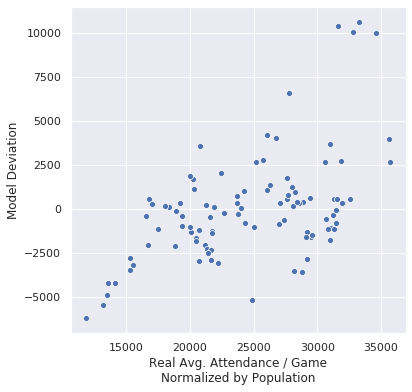

In [63]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=yo,y=yd)
plt.title = 'Attendance Model'
plt.xlabel('Real Avg. Attendance / Game\nNormalized by Population')
plt.ylabel('Model Deviation')

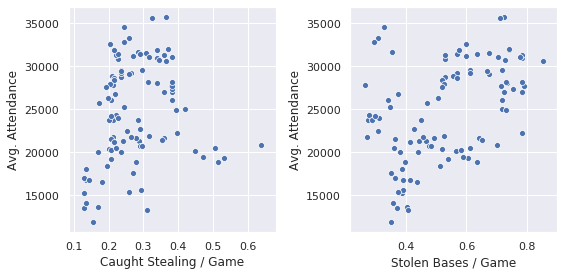

In [62]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
sns.scatterplot(x=X['CS/G'],y=yo)
plt.xlabel('Caught Stealing / Game')
plt.ylabel('Avg. Attendance')
plt.subplot(1,2,2)
sns.scatterplot(x=X['SB/G'],y=yo)
plt.xlabel('Stolen Bases / Game')
plt.ylabel('Avg. Attendance')
plt.tight_layout()
plt.title = 'Steals - Lure of the Unpredictable'

Text(0, 0.5, 'Avg. Attendance')

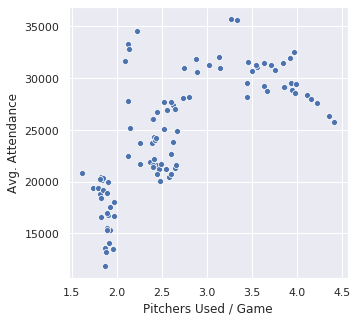

In [64]:
plt.figure(figsize=(5,5))
sns.scatterplot(x=X2s['Pitchers/G'],y=yo)
plt.xlabel('Pitchers Used / Game')
plt.ylabel('Avg. Attendance')

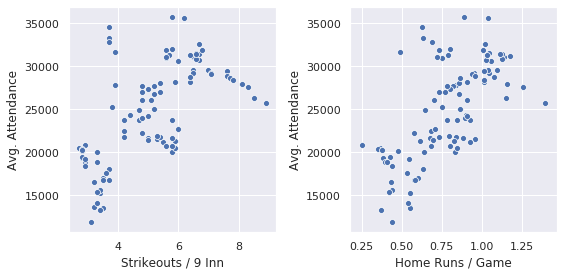

In [65]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
sns.scatterplot(x=X['SO9'],y=yo)
plt.xlabel('Strikeouts / 9 Inn')
plt.ylabel('Avg. Attendance')
plt.subplot(1,2,2)
sns.scatterplot(x=X['HR/G'],y=yo)
plt.xlabel('Home Runs / Game')
plt.ylabel('Avg. Attendance')
plt.tight_layout()